Run the cell below if you want to have output of the cells on their side
reload the page to get back to the default way.
You can edit background colors below (change the hex #RGB values)
Taken from:
https://github.com/jupyter/notebook/issues/2897#issuecomment-442959381

In [1]:
%%html
<style>
#notebook-container {
    width: 100%;
    background-color: #111
}

.code_cell {
   flex-direction: row !important;
}

.code_cell .output_wrapper {
    width: 50%;
    background-color: #333
}

.code_cell .input {
    width: 50%;
    background-color: #222
}
</style>

# Initialize
Run the cell below for imports and function definitions to happen.

Serial connection tries to be established. To reset the connection at any point, run the cell again.

In [2]:
# In case that serial conneciton is existing, it gets closed.
try:
    sc.serial.close()
except:
    pass

# To autoreload imported libraries:    
%load_ext autoreload
%autoreload 2

import logging
import time

import serial_connection

def flush():
    """
    Flush input buffer of the serial by reading and printing it's contetnts.
    
    There is a hardcoded limit on how many lines are read. If the buffer is empty
    sooner the reading stops.
    """
    flag_buffer_empty = False
    print('... Flushing... Lines in buffer:')
    for i in range(100):
        input_line = sc.readline()
        print(input_line)
        if len(input_line) <= 0:
            print('... nothing more to flush.')
            flag_buffer_empty = True
            break
    if not flag_buffer_empty:
        print('!! There might still be data in the buffer. Try flushing again.')
    print('... flushing done!')

    
# --- Init settings ------------------------------------------------------------    
# COM port to which Arduino is connected
# DAC1_port = 'COM23' # On the lab computer
DAC1_port = 'COM5'  # On my laptop

# Set the level of logging. (recommended: logging.INFO 
# for more output you can use: logging.DEBUG)
logging.basicConfig(level=logging.DEBUG)
# ------------------------------------------------------------------------------
    
# Start the serial connection
sc = serial_connection.serialConnection(port=DAC1_port, baud_rate=19200, string_terminator='\r')

# ### Settings on the Arduino
# scmd.addCommand("!TT", cmd_set_auto_timeout_time);  // _ #autoTimeoutTime
a = sc.send_string('!TT 200', wait_for_answer=False)
# scmd.addCommand("!TO", cmd_set_auto_timeout_on);    // _ #autoTimeoutOn (0 or 1)
a = sc.send_string('!TO 1', wait_for_answer=False)
# scmd.addCommand("!VM", cmd_set_voltage_max);        // _ #Vmax (in range 0 to 3000)
a = sc.send_string('!VM 2000', wait_for_answer=False)
# scmd.addCommand("!PA", cmd_setPrintAll);            // _ #printAll (0 or 1)
a = sc.send_string('!PA 0', wait_for_answer=False)

flush()    D:\Erik\Programming\Projects\MagneticTweezers\magnetic_tweezers_brugueslab\scripts\voltage_control\serial_connection.py

INFO:root:Serial opened on port COM5 with baud rate 19200
DEBUG:root:In send_string(): Encoded string: b'!TT 200\r'
DEBUG:root:In send_string(): Encoded string: b'!TO 1\r'
DEBUG:root:In send_string(): Encoded string: b'!VM 2000\r'
DEBUG:root:In send_string(): Encoded string: b'!PA 0\r'


... Flushing... Lines in buffer:
bytearray(b'Setup done.\r\n')
bytearray(b'File: V01_voltageControl.2\r\n')
bytearray(b'autoTimeoutTime set to 200\r\n')
bytearray(b'autoTimeoutOn set to 1\r\n')
bytearray(b'Vmax set to 2000\r\n')

... nothing more to flush.
... flushing done!


In [5]:
# ### (optional) Changing the logging level at any time
logging.getLogger().setLevel(logging.INFO)

In [3]:
# Test how the arduino - two tips - behaves:

# -------------------------------------------------
# One step of a measurement process:
voltage = 149
# Send control voltage to Arduino - Vin
a = sc.send_string('!VI ' + str(voltage), wait_for_answer=True)
VI = int(a.split(' ')[1])

# Read the voltage measurement - Vsense
a = sc.send_string('?VS', wait_for_answer=True)
VS = int(a.split(' ')[1])
t = time.time() - t_start


DEBUG:root:In send_string(): Encoded string: b'!VI 149\r'
DEBUG:root:In send_string(): Raw answer: bytearray(b'Unrecognized command.\r\n') type: <class 'bytearray'>
DEBUG:root:Answer is: bytearray(b'Unrecognized command.\r\n')
DEBUG:root:Answer decoded and stripped: "Unrecognized command."


ValueError: invalid literal for int() with base 10: 'command.'

# Run experiment

In [3]:
import numpy as np

measurements = []
# --- User settings -------------------------------------------------------------------

mode = ['step', 'sine', 'box'][2]
voltage_amplitude = 300 # Max voltage

t_signal_start = 1
t_signal_stop = 3

t_recording_stop = 4

dT = 0.05 # Approximate loop time - it's about 15 ms more
# -------------------------------------------------------------------------------------

t_start = time.time()
timer_loop_time = time.time()

while time.time() < t_start + t_recording_stop:
    t = time.time() - t_start
    if mode == 'step':
        if t > t_signal_start:
            voltage = voltage_amplitude
        else:
            voltage = 0
    elif mode == 'sine':
        voltage = int( 0.5*voltage_amplitude*(1 + np.sin(2*3.1415*t/10)) )
    elif mode == 'box':
        if t_signal_start <= t <= t_signal_stop:
            voltage = voltage_amplitude
        else:
            voltage = 0
    else:
        print('mode undefined')

    # Send control voltage to Arduino - Vin
    a = sc.send_string('!VI ' + str(voltage), wait_for_answer=True)
    VI = int(a.split(' ')[1])
    
    # Read the voltage measurement - Vsense
    a = sc.send_string('?VS', wait_for_answer=True)
    VS = int(a.split(' ')[1])
    t = time.time() - t_start

    measurements.append([t, VI, VS])
    while time.time() < timer_loop_time + dT:
        time.sleep(0.0001)
    timer_loop_time = time.time()

print('Done')

DEBUG:root:In send_string(): Encoded string: b'!VI 0\r'
DEBUG:root:In send_string(): Raw answer: bytearray(b'Unrecognized command.\r\n') type: <class 'bytearray'>
DEBUG:root:Answer is: bytearray(b'Unrecognized command.\r\n')
DEBUG:root:Answer decoded and stripped: "Unrecognized command."


ValueError: invalid literal for int() with base 10: 'command.'

# Plot the measurements

In [39]:
print([data[i, 0] - data[i-1, 0] for i in range(5, 50)])

[0.03099799156188965, 0.03280210494995117, 0.030484676361083984, 0.04558134078979492, 0.031996965408325195, 0.029593229293823242, 0.031128644943237305, 0.029798269271850586, 0.031111717224121094, 0.031850337982177734, 0.03053736686706543, 0.030608177185058594, 0.03191518783569336, 0.03194594383239746, 0.03041839599609375, 0.03191661834716797, 0.031867265701293945, 0.032244205474853516, 0.029549121856689453, 0.031911611557006836, 0.030265331268310547, 0.030008554458618164, 0.032128334045410156, 0.02926945686340332, 0.032128334045410156, 0.03183150291442871, 0.030972719192504883, 0.0334477424621582, 0.030678987503051758, 0.03178238868713379, 0.0310819149017334, 0.03155374526977539, 0.031113862991333008, 0.03117203712463379, 0.030849695205688477, 0.030764102935791016, 0.030369281768798828, 0.031889915466308594, 0.030210018157958984, 0.03128385543823242, 0.030321598052978516, 0.03135490417480469, 0.032285451889038086, 0.031043529510498047, 0.03140664100646973]


<IPython.core.display.Javascript object>


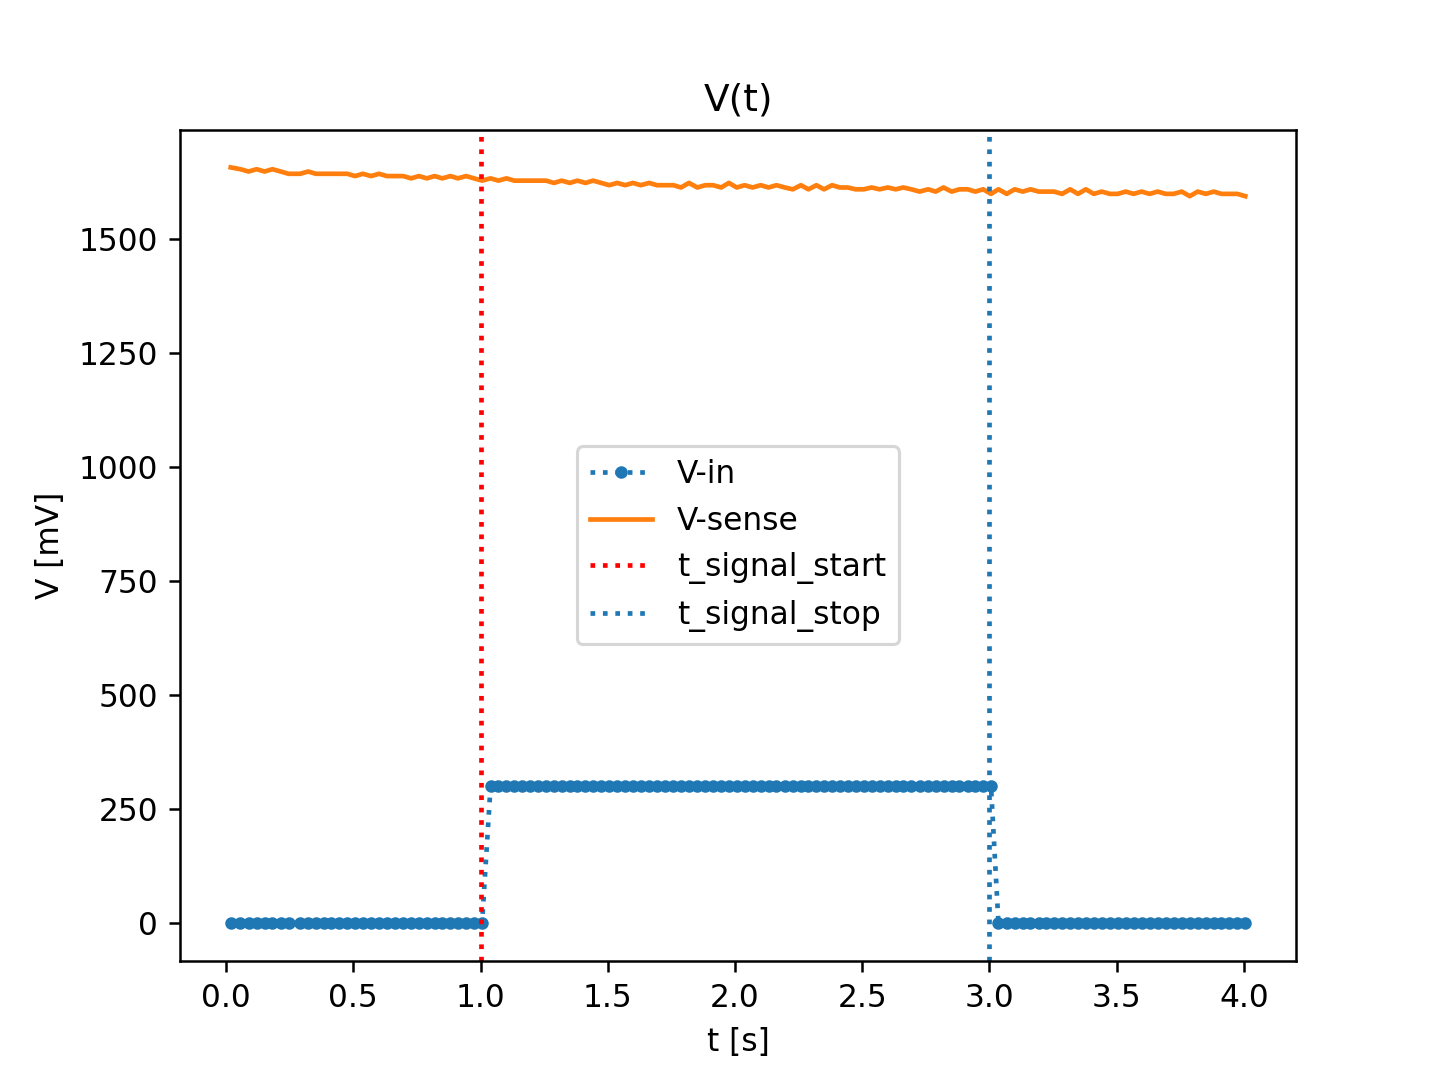

In [38]:
import matplotlib.pyplot as plt
%matplotlib notebook 
    
data = np.array(measurements)
fig = plt.figure()
fig.patch.set_facecolor('white')


plt.plot(data[:, 0], data[:, 1], ':.', label='V-in')
plt.plot(data[:, 0], data[:, 2], label='V-sense')
# Visual aids:
plt.axvline(t_signal_start, ls=':', c='r', label='t_signal_start')
plt.axvline(t_signal_stop, ls=':', label='t_signal_stop')
plt.title('V(t)')
plt.legend()
plt.xlabel('t [s]')
plt.ylabel('V [mV]')
plt.show()


### Saving the measurements to a file

In [11]:
# File counter is used for naming of saved files - it will overwrite saved files 
# when the same number.
file_counter = 0

In [12]:
# Save the data to text file
folder = 'measurements/'

file_counter += 1
file_name = folder + 'voltage_timeseries_' + str(file_counter) + '.txt'

comment = input('Enter the comment for the saved file:')
header_text = 't[s] Vin[mV] Vsense[mV]    comment: ' + comment
np.savetxt(file_name, data, header=header_text)
print('File saved. Name:', file_name)


Enter the comment for the saved file:First test of real timing.
File saved. Name: measurements/voltage_timeseries_1.txt


# Functions for debugging
Should be moved to other files or integrated into source scripts at some point.

In [1]:
"""To get the list of serial ports"""
import sys
import glob
import serial


def serial_ports():
    """ Lists serial port names

        :raises EnvironmentError:
            On unsupported or unknown platforms
        :returns:
            A list of the serial ports available on the system
    """
    if sys.platform.startswith('win'):
        ports = ['COM%s' % (i + 1) for i in range(256)]
    elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
        # this excludes your current terminal "/dev/tty"
        ports = glob.glob('/dev/tty[A-Za-z]*')
    elif sys.platform.startswith('darwin'):
        ports = glob.glob('/dev/tty.*')
    else:
        raise EnvironmentError('Unsupported platform')

    result = []
    for port in ports:
        try:
            s = serial.Serial(port)
            s.close()
            result.append(port)
        except (OSError, serial.SerialException):
            pass
    return result


print('Available serial ports:')
print(serial_ports())


Available serial ports:
['COM4', 'COM8']
